# Coherence and Directionality

This notebook will illustrate how to calculate the coherence between two signals, and then the directionality of information flow between two areas. Specifically, this notebook shows how to quantify:
1. Coherence + phase offset in the frequecy domain
2. Coherence + phase offset in the time-frequency domains
3. Amplitude correlation
4. Phase slope index

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import mne_connectivity
from mne import create_info, EpochsArray
from scipy.signal import butter, filtfilt, hilbert

Let's simulate two signals with a coherent 20Hz oscillation

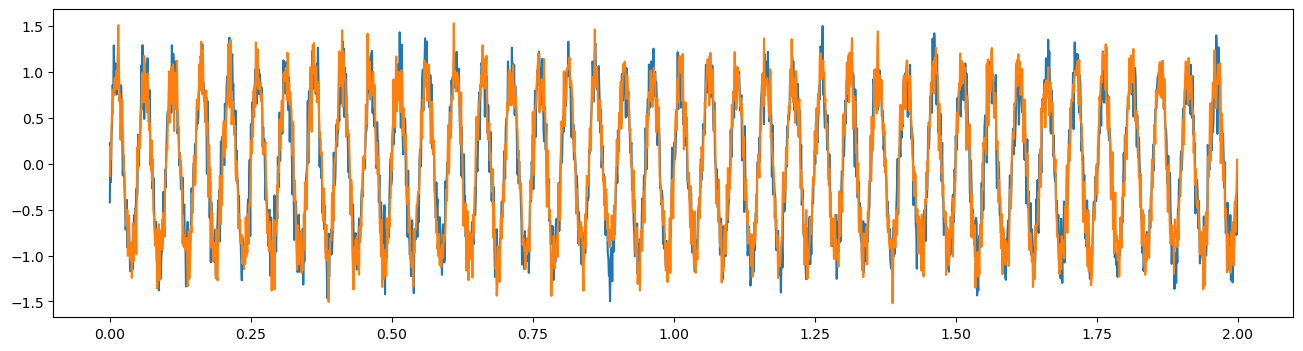

In [2]:
fs = 1000
times = np.arange(0, 2, 1/fs)
freq = 20
osc = np.sin(2 * np.pi * times[:] * freq)
lfp1 = osc + np.random.normal(0, .2, size=times.shape)
lfp2 = osc + np.random.normal(0, .2, size=times.shape)
plt.figure(figsize=(16,4))
plt.plot(times, lfp1, label='lfp1')
plt.plot(times, lfp2, label='lfp2')

Now, let's measure the coherence. To do so, we'll first need to calculate the **cross spectral density** between the two signals. The difference between power and coherence comes down to performing an autocorrelation instead of a cross correlation. Where the autocorrelation of a signal is computed by convolving a signal with itself, a cross-correlation is computed by convolving one signal with another. The power spectral density is then the Fourier Transform of the autocorrelation, and the cross spectral density is the Fourier Transform of the cross-correlation.

Coherence is computed as the magnitude-squared cross spectral density, normalized by the power spectrum of each signal [[1]](#References). Therefore, coherence will be between 0 (where the two signals are completely uncorrelated) and 1 (where the two signals are perfectly correlated) at each frequency.

The equation for computing coherence is therefore $Coh_{xy} = \frac{|Pxy|^{2}}{Pxx*Pyy}$, where Pxx is the power spectrum of x, Pyy is the power spectrum of y, and Pxy is the cross spectrum of x and y.

Therefore, the power spectrum of a signal can be thought of as the coherence of a signal with itself. As a result, we can use scipy's *csd* function both to compute the cross spectrum between x and y, and their power spectrum for computation of coherence. This function computes each spectrum using Welch's method.

Text(0, 0.5, 'Coherence')

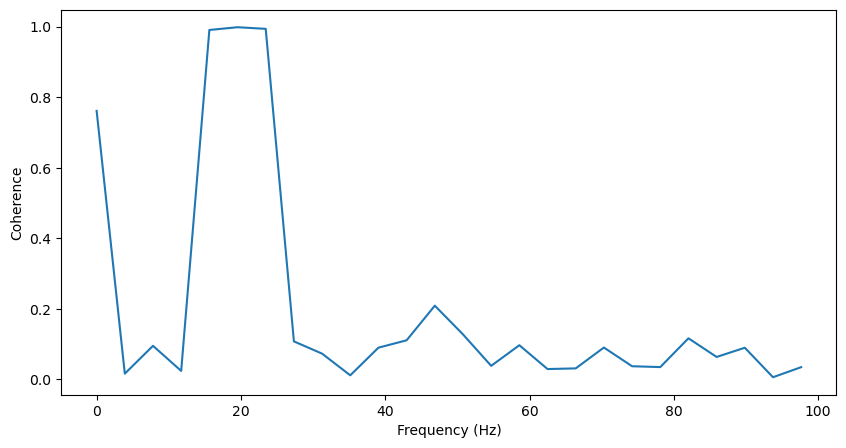

In [3]:
f, Pxx = scipy.signal.csd(lfp1, lfp1, fs=fs)
f, Pyy = scipy.signal.csd(lfp2, lfp2, fs=fs)
f, Pxy = scipy.signal.csd(lfp1, lfp2, fs=fs)
Coh_xy = (np.abs(Pxy)**2) / (Pxx*Pyy)
Coh_xy = Coh_xy[np.where(f<100)]
f = f[np.where(f<100)]
plt.figure(figsize=(10,5))
plt.plot(f, Coh_xy)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')

We can also (more conviently) use scipys *coherence* function, and obtain the same results:

Text(0, 0.5, 'Coherence')

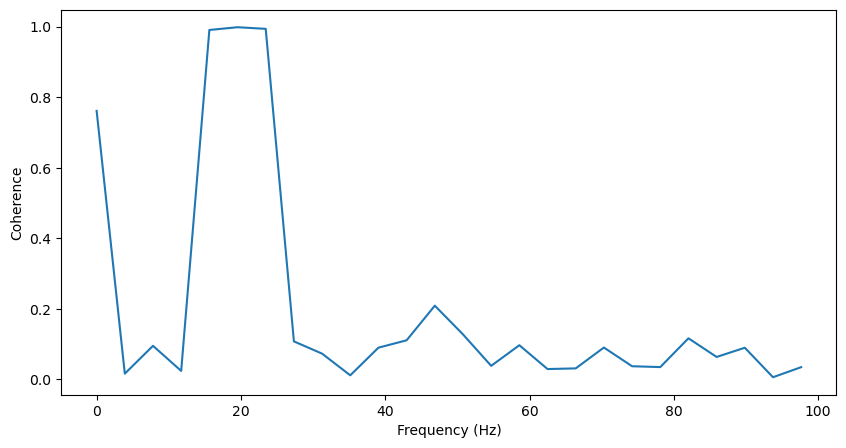

In [4]:
f, coh = scipy.signal.coherence(lfp1, lfp2, fs=fs)
coh = coh[np.where(f<100)]
f = f[np.where(f<100)]
plt.figure(figsize=(10,5))
plt.plot(f, coh)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')

We can also get the phase difference between the two signals at each frequency just by taking the phase of Pxy.

Text(0, 0.5, 'Phase difference (radians)')

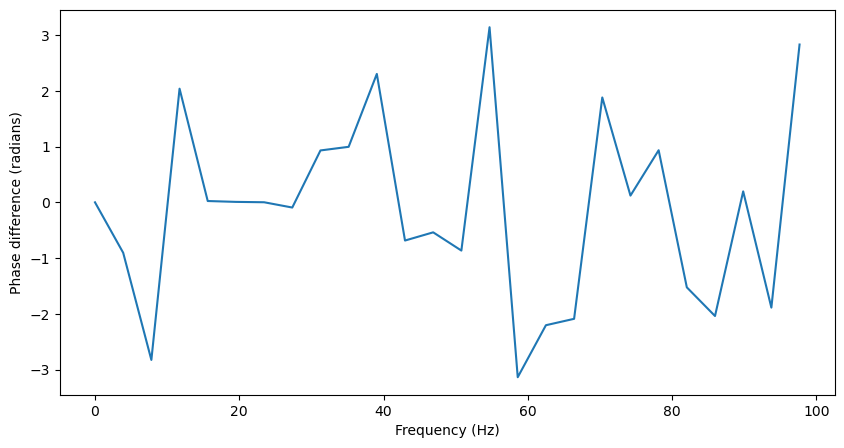

In [5]:
Pxy = Pxy[:f.shape[0]]
plt.figure(figsize=(10,5))
plt.plot(f, np.angle(Pxy))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase difference (radians)')

Because there is no phase lag between the two signals in the 20Hz oscillation, the this phase difference should be close to 0 at 20Hz, but essentially random at other frequencies.

## Time-frequency

Now, let's try computing coherence in the time frequency domain. This is not as straightforward as computing power in the time frequency domain. Coherence is essentially a correlation measure, and to compute a correlation, you need multiple samples from each signal. Therefore, we cannot take two signals and compute their coherence at each sample. Instead, there are two common approaches to compute coherence in the time-frequency domains. The first is to compute coherence in windows over time, or after smoothing the data over time resulting in decreased resolution over time [[2]](#References). The other is to compute the coherence over trials, rather than time, allowing for an estimation of time frequency coherence without any loss of time or frequency resolution. 

Just like for time-frequency analysis of power, we can use MNE supported time-frequency decompositon via morlet wavelets to compute time-frequency coherence. First, let's simulate two signals where their coherence changes over time. 

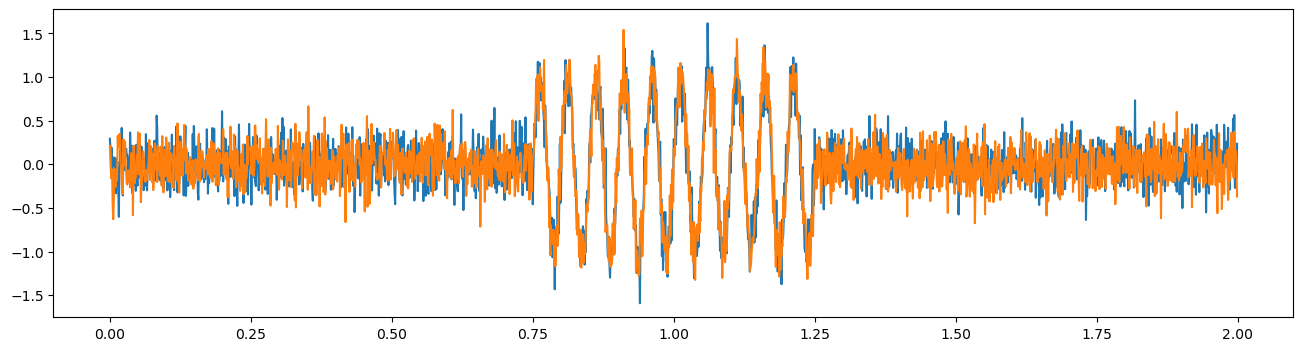

In [6]:
times = np.arange(0, 2, 1/fs)
lfp1 = np.random.normal(0, .2, size=times.shape)
lfp2 = np.random.normal(0, .2, size=times.shape)
lfp1[750:1250] += np.sin(2 * np.pi * times[:] * 20)[750:1250]
lfp2[750:1250] += np.sin(2 * np.pi * times[:] * 20)[750:1250]
plt.figure(figsize=(16,4))
plt.plot(times, lfp1, label='lfp1')
plt.plot(times, lfp2, label='lfp2')

Now let's try computing time frequency coherence over time on single trials, using MNE's [spectral_connectivity_time](https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.spectral_connectivity_time.html) function. We'll again need to format the data for mne (for this function, data must be formatted into an mne epochs structure).

In [7]:
info = create_info(ch_names=list(map(str, np.arange(1, 3, 1))), sfreq=fs, ch_types=['eeg','eeg'])
epochs = np.empty((1, 2, len(times)))
epochs[0,0,:] = lfp1[int(round(times[0]*fs)):int(round(times[-1]*fs))+1] #Format data into [epochs, channels, samples] format
epochs[0,1,:] = lfp2[int(round(times[0]*fs)):int(round(times[-1]*fs))+1] #Format data into [epochs, channels, samples] format
epochs = EpochsArray(epochs, info, verbose=False)

freqs = np.arange(1,100)
n_cycles = freqs/2
con = mne_connectivity.spectral_connectivity_time(epochs, method='coh', sfreq=int(fs),
                                                                        mode='cwt_morlet', freqs=freqs,
                                                                        n_cycles=n_cycles, verbose=True)

Connectivity computation...


C:\Users\Michael\AppData\Local\Temp\ipykernel_4552\2007432969.py:9: RuntimeWarning: There were no Annotations stored in <EpochsArray |  1 events (all good), 0 - 1.999 sec, baseline off, ~39 kB, data loaded,
 '1': 1>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_time(epochs, method='coh', sfreq=int(fs),


  0%|          |  : 0/3 [00:00<?,       ?it/s]

Text(0, 0.5, 'Frequency (Hz)')

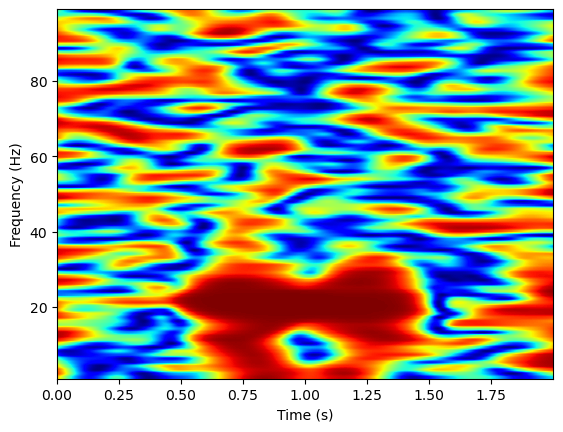

In [8]:
#Plot
coh = con.get_data()
coh = coh[0,0,1,:,:]
plt.imshow(np.squeeze(coh), extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='jet')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
# TODO: plot phase on this

Now, we'll simulate the data over many trials, and compute the coherence over trials using MNE's [spectral_connectivity_epochs](https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.spectral_connectivity_epochs.html) function. This function takes a numpy array structure, rather than an mne epochs structure for its data input.

In [9]:
osc = np.sin(2 * np.pi * times[:] * 20)[750:1250]
trials = 10
epochs = np.empty((trials, 2, len(times)))

for trial in range(0, trials):
    lfp1 = np.random.normal(0, .2, size=times.shape)
    lfp2 = np.random.normal(0, .2, size=times.shape)
    lfp1[750:1250] += osc
    lfp2[750:1250] += osc
    epochs[trial, 0, :] = lfp1
    epochs[trial, 1, :] = lfp2

In [10]:
freqs = np.arange(1,100)
n_cycles = freqs/2
con = mne_connectivity.spectral_connectivity_epochs(epochs, method='coh', sfreq=int(fs),
                                                   mode='cwt_morlet', cwt_freqs=freqs,
                                                   cwt_n_cycles=n_cycles, verbose=True,
                                                   indices=(np.array([0]), np.array([1])))                                                   

Connectivity computation...


    computing connectivity for 1 connections


    using t=0.000s..1.999s for estimation (2000 points)


    frequencies: 3.0Hz..99.0Hz (97 points)


    using CWT with Morlet wavelets to estimate spectra


    the following metrics will be computed: Coherence


    computing connectivity for epoch 1


    computing connectivity for epoch 2


    computing connectivity for epoch 3


    computing connectivity for epoch 4


    computing connectivity for epoch 5


    computing connectivity for epoch 6


    computing connectivity for epoch 7


    computing connectivity for epoch 8


    computing connectivity for epoch 9


    computing connectivity for epoch 10


[Connectivity computation done]


Text(0, 0.5, 'Frequency (Hz)')

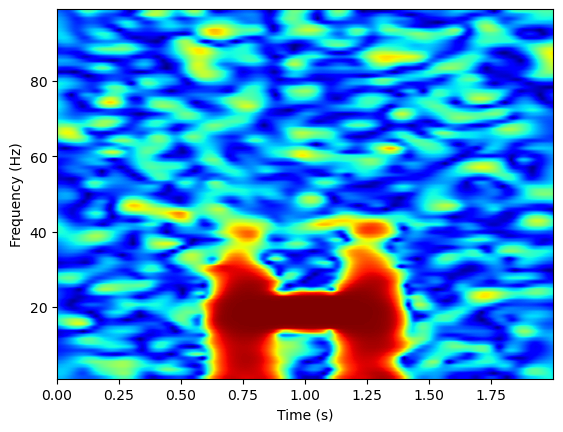

In [11]:
coh = con.get_data()

plt.imshow(np.squeeze(coh), extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='jet')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

**Phase**

Just as for coherence in frequency space, we can get the phase difference of time-frequency coherence. To do so, we first get the complex coherence values, containing both the amplitude and phase information of the coherence, by setting the method parameter of the spectral_connectivity function to 'cohy'. We can get the amplitude of the coherence (the same metric computed originally) by taking the absolute value of this output, and the phase by taking the angle.

In [12]:
con_complex = mne_connectivity.spectral_connectivity_epochs(epochs, method='cohy', sfreq=int(fs),
                                                   mode='cwt_morlet', cwt_freqs=freqs,
                                                   cwt_n_cycles=n_cycles, verbose=False,
                                                   indices=(np.array([0]), np.array([1])))
                                                   
coh_complex = con_complex.get_data()
coh_phase = np.angle(coh_complex)
coh = np.abs(coh_complex)

Connectivity computation...


    computing connectivity for 1 connections


    using t=0.000s..1.999s for estimation (2000 points)


    frequencies: 3.0Hz..99.0Hz (97 points)


    using CWT with Morlet wavelets to estimate spectra


    the following metrics will be computed: Coherency


    computing connectivity for epoch 1


    computing connectivity for epoch 2


    computing connectivity for epoch 3


    computing connectivity for epoch 4


    computing connectivity for epoch 5


    computing connectivity for epoch 6


    computing connectivity for epoch 7


    computing connectivity for epoch 8


    computing connectivity for epoch 9


    computing connectivity for epoch 10


[Connectivity computation done]


We can plot both the amplitude and phase of the coherence on the same plot by plotting the phase information as a quiver plot. Since the coherence output contains data for every sample and every frequency, I select a subset of the phase values to plot.

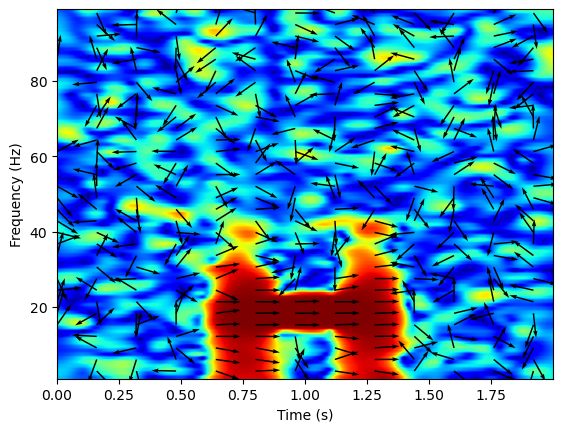

In [13]:
plt.imshow(np.squeeze(coh), extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='jet')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
coh_phase = np.squeeze(coh_phase)
X, Y = np.meshgrid(np.linspace(times[0], times[-1], coh_phase.shape[1]), np.linspace(freqs[0], freqs[-1], coh_phase.shape[0]))

U = np.cos(coh_phase)
V = np.sin(coh_phase)
f_x = 160
f_y = 3
plt.quiver(X[2::f_y, ::f_x], Y[2::f_y, ::f_x], U[2::f_y, ::f_x], V[2::f_y, ::f_x], angles='uv', scale=20)

## Directionality

If two signals (brain areas) are correlated, that could mean they both are affecting each other's activity, or one area is primarily driving another. Therefore, after analyzing the coherence between two signals, it is often useful to analyze the directionality of any relationship between two signals. Here, I will discuss two common methods for assessing directionality in neuroscience: **amplitude correlations** and the **phase slope index**.

First, we'll simulate data such that lfp2 lags lfp1.

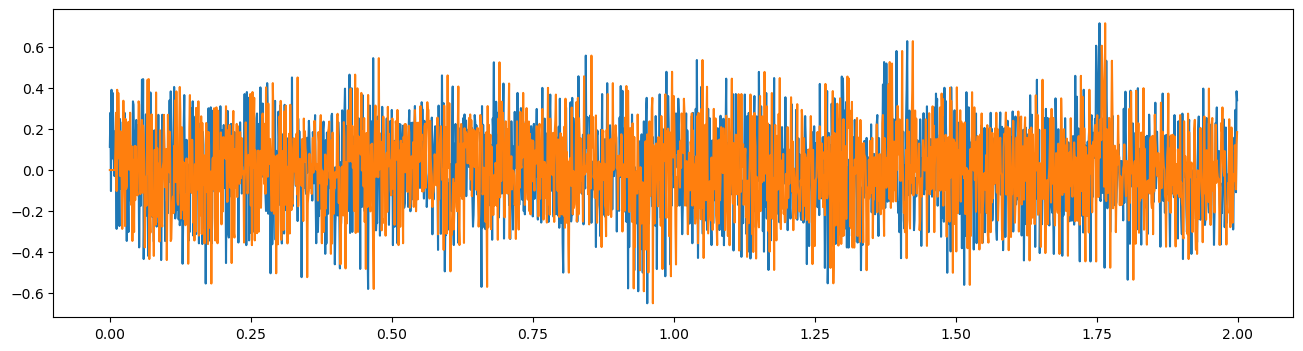

In [14]:
# Simulate data
lag = 10
samples = 2000
lfp2 = np.zeros(samples)
lfp1 = np.random.normal(0, .2, size=samples)
lfp2[lag:] = lfp1[:samples-lag]

# lfp1[750:1250] += np.sin(2 * np.pi * times[:] * 20)[0:500]
# lfp2[750+lag:1250+lag] += lfp1[750:1250]

plt.figure(figsize=(16,4))
plt.plot(times, lfp1, label='lfp1')
plt.plot(times, lfp2, label='lfp2')

## Amplitude Correlation

The amplitude correlation is a straightforward method of computing the directionality between two signals. Also referred to as a power envelope correlation [[3]](#References), the method is a cross-correlation of the amplitudes in a frequency between two signals. The first step of this method is to filter each signal in the frequency band of interest, and then compute the amplitude envelope of each by taking the hilbert transform of the filtered signal. Then a cross-correlation is performed between the two amplitude envelopes. Therefore, the amplitude correlation can indicate when the power of the oscillation is most correlated between the two signals, revealing whether an oscillation in one signal precedes or follows an oscillation in another signal.

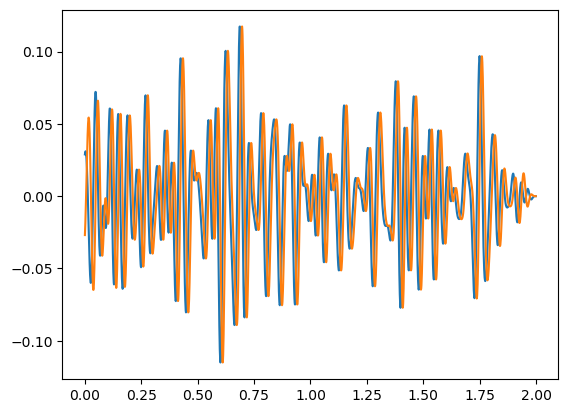

In [15]:
#Filter
order=4
freq_band = [12, 32]
b, a = butter(order, freq_band, fs=fs, btype='band')
lfp1_filt = filtfilt(b, a, lfp1, padtype=None)
lfp2_filt = filtfilt(b, a, lfp2, padtype=None)
plt.plot(times, lfp1_filt)
plt.plot(times, lfp2_filt)

Correlation is maximal where lag = -10ms


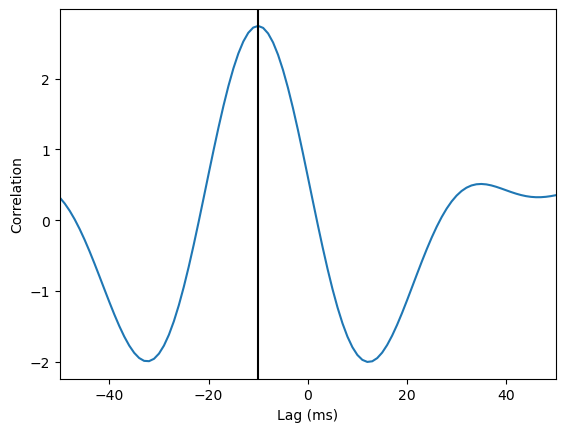

In [16]:
lfp1_analytic = hilbert(lfp1_filt)
lfp2_analytic = hilbert(lfp2_filt)
xcorr = scipy.signal.correlate(lfp1_filt, lfp2_filt)
lags = scipy.signal.correlation_lags(len(lfp1_analytic), len(lfp2_analytic))
plt.plot(lags, xcorr)
plt.xlim(-50, 50)
plt.xlabel('Lag (ms)')
plt.ylabel('Correlation')
plt.axvline(lags[np.argmax(xcorr)], color='black')
print('Correlation is maximal where lag = '+str(lags[np.argmax(xcorr)])+'ms')

The two signals are most correlated when the second signal is shifted backwards in time by 10ms, indicating the second signal lags the first by 10ms.

## Phase Slope Index
A second method to assess the directionality of information flow is the phase slope index (PSI) [[4]](#References). Phase is circular, and thus cannot indicate directionality in itself. However, taking the phase difference over a range of frequencies, one can begin to interpret directionality. PSI assumes one brain area interacts with another with some time offset, such that the speed at which different waves travel is similar. Since the same time difference will result in larger phase differences as frequency increases, there should be a positive slope in the phase spectrum. Therefore, PSI quantifies the slope of the phase spectrum, such that a positive slope indicates the first signal leads the second, and a negative signal indicates the reverse.

In [17]:
# Compute PSI
epochs = np.empty((1, 2, len(times)))
epochs[0,0,:] = lfp1 #Format data into [epochs, channels, samples] format
epochs[0,1,:] = lfp2 #Format data into [epochs, channels, samples] format
minf = 60
maxf = 100
freqs = np.arange(minf, maxf, 2)
n_cycles = freqs/2
# con = mne_connectivity.SpectralConnectivity(epochs, n_nodes=2, freqs=np.arange(minf,maxf,2), method='cohy', indices=[np.asarray(0), np.asarray(1)])
con = mne_connectivity.phase_slope_index(epochs, sfreq=int(fs), verbose=True, fmin=minf, fmax=maxf, indices=(np.array([0]), np.array([1])))

Estimating phase slope index (PSI)


Connectivity computation...


    computing connectivity for 1 connections


    using t=0.000s..1.999s for estimation (2000 points)


    frequencies: 60.0Hz..100.0Hz (81 points)


    Using multitaper spectrum estimation with 7 DPSS windows


    the following metrics will be computed: Coherency


    computing connectivity for epoch 1


[Connectivity computation done]


Computing PSI from estimated Coherency: <SpectralConnectivity | freq : [60.000000, 100.000000], , nave : 1, nodes, n_estimated : 2, 1, ~68 kB>


[PSI Estimation Done]


Connectivity computation...


    computing connectivity for 1 connections


    using t=0.000s..1.999s for estimation (2000 points)


    frequencies: 60.0Hz..98.0Hz (20 points)


    using CWT with Morlet wavelets to estimate spectra


    the following metrics will be computed: Coherency


    computing connectivity for epoch 1


[Connectivity computation done]


Text(0, 0.5, 'Phase offset (radians)')

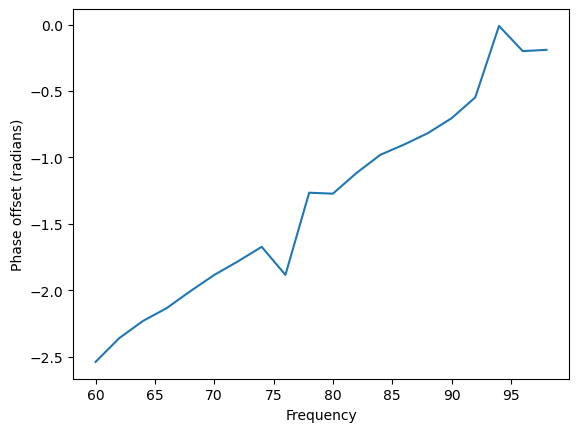

In [18]:
# Plot the relationship between phase difference and frequency
con_complex = mne_connectivity.spectral_connectivity_epochs(epochs, method='cohy', sfreq=int(fs),
                                                   mode='cwt_morlet', cwt_freqs=freqs,
                                                   cwt_n_cycles=n_cycles, verbose=False,
                                                   indices=(np.array([0]), np.array([1])))
                                                   
coh_complex = con_complex.get_data()
coh_phase = np.angle(coh_complex)

#Plot the phase slope for one timepoint
plt.plot(freqs, coh_phase[0,:,1000])
plt.xlabel('Frequency')
plt.ylabel('Phase offset (radians)')

In [19]:
psi = con.get_data()
print(psi)

[[2.49877028]]


The slope of the phase offset by frequency graph is positive, leading to a positive PSI. This suggests lfp1 leads lfp2, as we know to be correct.

## References
1. Stoica, Petre, and Randolph Moses, “Spectral Analysis of Signals” Prentice Hall, 2005
2. Sandberg, J., & Hansson, M. (2006). Coherence estimation between EEG signals using multiple window time-frequency analysis compared to Gaussian kernels. IEEE.
3. Hipp, J. F., Hawellek, D. J., Corbetta, M., Siegel, M., & Engel, A. K. (2012). Large-scale cortical correlation structure of spontaneous oscillatory activity. Nature Neuroscience 2012 15:6, 15(6), 884–890. https://doi.org/10.1038/nn.3101
4. Nolte, G., Ziehe, A., Nikulin, V. V., Schlögl, A., Krämer, N., Brismar, T., & Müller, K. R. (2008). Robustly estimating the flow direction of information in complex physical systems. Physical Review Letters, 100(23). https://doi.org/10.1103/PHYSREVLETT.100.234101